In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
!ls

README.md            solution.ipynb       tic-tac-toe.data.txt


In [3]:
df = pd.read_csv("tic-tac-toe.data.txt", sep=',', names = list(range(9)) + ['target'])
df.head()

,0,1,2,3,4,5,6,7,8,target
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [4]:
import copy
def dummy_encode_categorical_columns(data):
    result_data = copy.deepcopy(data)
    for column in data.columns.values:
        result_data = pd.concat(
            [result_data, pd.get_dummies(result_data[column],
                                         prefix = column, prefix_sep = '_')], axis = 1)
        del result_data[column]
    return result_data
df = dummy_encode_categorical_columns(df)
df['target'] = df['target_positive']
df = df.drop(['target_positive', 'target_negative'], axis=1)
df.head()

,0_b,0_o,0_x,1_b,1_o,1_x,2_b,2_o,2_x,3_b,...,6_b,6_o,6_x,7_b,7_o,7_x,8_b,8_o,8_x,target
0,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,1
1,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,1
2,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,1
3,0,0,1,0,0,1,0,0,1,0,...,0,1,0,1,0,0,1,0,0,1
4,0,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1


In [5]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3)
len(df_train), len(df_test)

(670, 288)

In [6]:
X_train, y_train = df_train.drop(['target'], axis=1), df_train['target']
X_test, y_test = df_test.drop(['target'], axis=1), df_test['target']

In [7]:
X_train_pos = np.array(X_train[y_train == 1])
X_train_neg = np.array(X_train[y_train == 0])

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

KOEFF_PODGONA = 0.8
def get_impact(obj, X, weight_power):
    impact = 0
    for x in X:
        common_ids = (obj == x)
        weight = np.sum(common_ids) / len(common_ids)
        closure_power = np.sum(np.all(obj[common_ids] == X[:, common_ids], axis=1)) - 1
        assert(closure_power >= 0)
        impact += closure_power * (weight**weight_power)
    impact /= len(X)
    return impact
    
def apply(weight_power):
    y_pred = np.zeros(len(X_test), dtype=np.int32)
    for i, test_obj in tqdm(enumerate(np.array(X_test)), position=0):
        positive_impact = get_impact(test_obj, X_train_pos, weight_power)
        negative_impact = get_impact(test_obj, X_train_neg, weight_power)
        y_pred[i] = (positive_impact * KOEFF_PODGONA > negative_impact)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return accuracy, precision, recall

In [9]:
accuracy, precision, recall = apply(5)
print("acc : {}, precision : {}, recall : {}".format(accuracy, precision, recall))

288it [00:08, 33.07it/s]

acc : 0.8680555555555556, precision : 0.8483412322274881, recall : 0.9675675675675676


In [10]:
weight_power_range = [2, 3, 4, 8, 16, 20, 25, 28, 32, 45, 55, 64]
accuracy_all, precision_all, recall_all = [], [], []
for weight_power in weight_power_range:
    accuracy, precision, recall = apply(weight_power)
    accuracy_all.append(accuracy)
    precision_all.append(precision)
    recall_all.append(recall)    

288it [00:07, 37.25it/s]
288it [00:07, 40.09it/s]
288it [00:07, 40.24it/s]
288it [00:07, 37.28it/s]
288it [00:07, 38.49it/s]
288it [00:07, 40.01it/s]
288it [00:07, 40.32it/s]
288it [00:06, 41.31it/s]
288it [00:07, 36.11it/s]
288it [00:08, 36.21it/s]
288it [00:07, 36.41it/s]
288it [00:07, 37.91it/s]


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

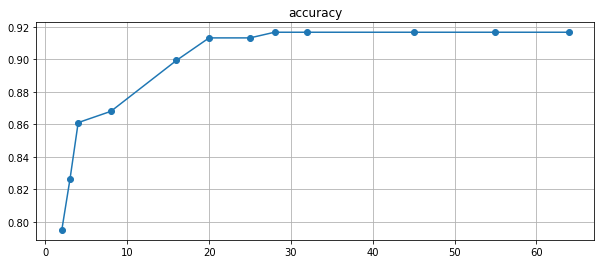

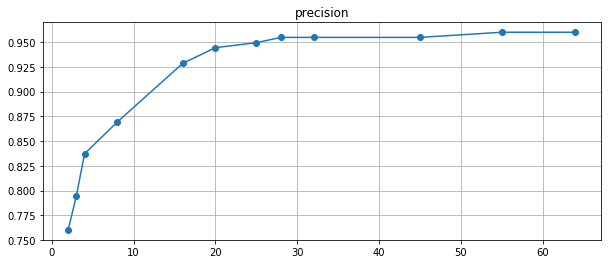

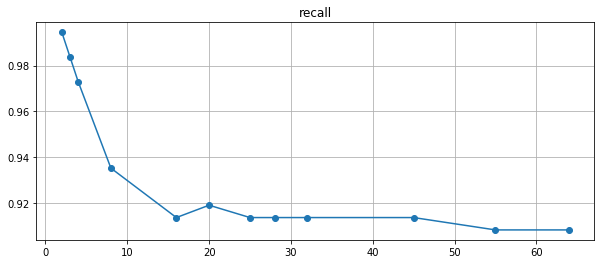

In [12]:
metrics = (accuracy_all, precision_all, recall_all)
names = ("accuracy", "precision", "recall")
for name, metric in zip(names, metrics):
    plt.figure(figsize=(10,4))
    plt.grid(True)
    plt.title(name)
    plt.plot(weight_power_range, metric, '-o')
    plt.show()